In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from keras import layers

In [4]:
img_width = 180
img_height = 180
batch_size = 32

In [5]:
data_dir = 'Plant_diseases_dataset'

In [6]:
# Create training dataset with 80% of the data
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, # 20% for validation/test
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 61486 files belonging to 39 classes.
Using 49189 files for training.


In [7]:
# Create validation dataset with 20% of the data, split further into validation and test
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 61486 files belonging to 39 classes.
Using 12297 files for validation.


In [8]:
# Determine the number of validation batches to use for a test set
# For example, if val_ds has 100 batches, we can use the first 50 for validation and the next 50 for testing
val_batches = tf.data.experimental.cardinality(val_ds).numpy()
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

Number of training batches: 1538
Number of validation batches: 193
Number of test batches: 192


In [9]:
# Get class names
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Number of classes: 39
Class names: ['Apple Black Rot', 'Apple Cedar Rust', 'Apple Scab', 'Cherry Powdery Mildew', 'Corn Cercospora Leaf Spot', 'Corn Common Rust', 'Corn Northern Leaf Blight', 'Grape Black Measles', 'Grape Black Rot', 'Grape Leaf Blight', 'Healthy Apple', 'Healthy Blueberry', 'Healthy Cherry', 'Healthy Corn', 'Healthy Grape', 'Healthy Peach', 'Healthy Pepper Bell', 'Healthy Potato', 'Healthy Raspberry', 'Healthy Soybean', 'Healthy Strawberry', 'Healthy Tomato', 'No Leaf Image', 'Orange Haunglongbing (Citrus Greening)', 'Peach Bacterial Spot', 'Pepper Bell Bacterial Spot', 'Potato Early Blight', 'Potato Late Blight', 'Squash Powdery Mildew', 'Strawberry Leaf Scorch', 'Tomato Bacterial Spot', 'Tomato Early Blight', 'Tomato Late Blight', 'Tomato Leaf Mold', 'Tomato Mosaic Virus', 'Tomato Septoria Leaf Spot', 'Tomato Spider Mites', 'Tomato Target Spot', 'Tomato Yellow Leaf Curl Virus']


In [10]:
model = tf.keras.Sequential([
        # Explicitly define the input shape as the first layer
        tf.keras.Input(shape=(img_height, img_width, 3)),
        
        # Data augmentation
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        
        # Rescaling layer (to normalize pixel values from [0, 255] to [0, 1])
        layers.Rescaling(1./255),

        # Convolutional Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25), # Added Dropout

        # Convolutional Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25), # Added Dropout

        # Convolutional Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25), # Added Dropout

        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5), # Added Dropout
        layers.Dense(num_classes, activation='softmax') # Output layer
    ])

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Early Stopping: Stop training if validation accuracy doesn't improve for 10 epochs
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpoint: Save the best model based on validation accuracy
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras', # Path to save the best model
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [13]:
initial_epochs = 10
history = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model on the test set
print("\nEvaluating on test set:")
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.2519 - loss: 2.8232
Epoch 1: val_accuracy improved from -inf to 0.54559, saving model to best_model.keras
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 1226s 709ms/step - accuracy: 0.2520 - loss: 2.8228 - val_accuracy: 0.5456 - val_loss: 1.4986
Epoch 2/10
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.5598 - loss: 1.4805
Epoch 2: val_accuracy improved from 0.54559 to 0.68406, saving model to best_model.keras
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 1062s 691ms/step - accuracy: 0.5599 - loss: 1.4804 - val_accuracy: 0.6841 - val_loss: 1.0454
Epoch 3/10
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.6339 - loss: 1.2049
Epoch 3: val_accuracy improved from 0.68406 to 0.71412, saving model to best_model.keras
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 1034s 672ms/step - accuracy: 0.6339 - loss: 1.2049 - val_accuracy: 0.7141 - val_loss: 0.9027
Epoch 4/10
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.6715 - loss: 1.0741
Epoc

Text(0.5, 1.0, 'Loss')

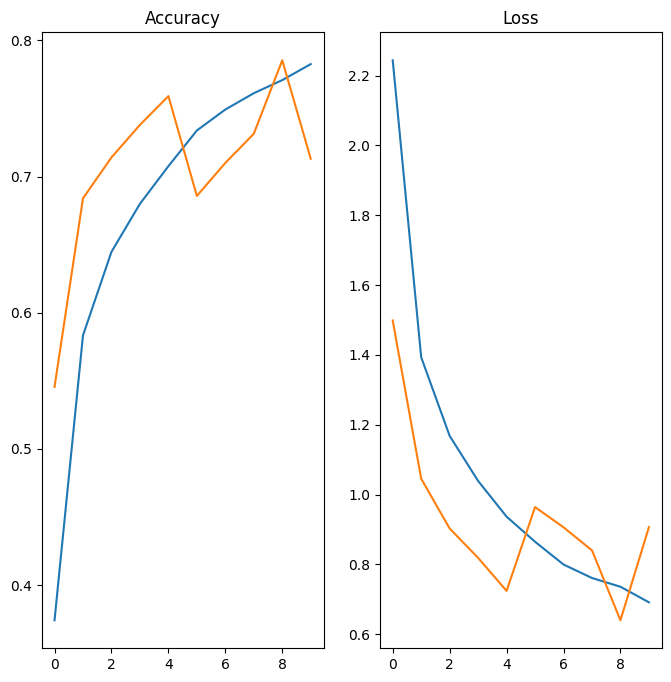

In [15]:
epochs_range = range(initial_epochs)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, 
         history.history['accuracy'], 
         label='Training Accuracy')
plt.plot(epochs_range, 
         history.history['val_accuracy'], 
         label='Validation Accuracy')
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, 
         history.history['loss'], 
         label='Training Loss')
plt.plot(epochs_range, 
         history.history['val_loss'], 
         label='Validation Loss')
plt.title('Loss')

In [16]:
image = 'Plants-leaves-images/1.png'
image = tf.keras.utils.load_img(
    image, 
    target_size=(img_height, img_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat = tf.expand_dims(img_arr, 0)

In [17]:
predict = model.predict(img_bat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


In [18]:
score = tf.nn.softmax(predict[0])

In [20]:
print('Veg/Fruit in image is {} with accuracy of {:0.2f}'.format(class_names[np.argmax(score)], np.max(score)*100))

Veg/Fruit in image is Apple Black Rot with accuracy of 6.65


In [ ]:
model.save('PlantsLeaves_classify_2.keras')